In [76]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
import re
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim.models.word2vec as w2v

# Data Preprocessing and EDA
- Data was read in from the combined JSON files from the previous step. Twitter handles and taster photos were removed because of irrelevance. Basic descriptive statistics are reviewed for outliers and total unique values for each category. There is a significant outlier in the price column and will be addressed for more accurate EDA. Duplicates wine title are dropped. 

In [77]:
wine = pd.read_csv('data/2022_winemag_reviews.csv',index_col='Unnamed: 0')
#no need for twitter handle or photo
wine.drop(columns=['taster_twitter_handle','taster_photo'],inplace = True)

In [140]:
wine.shape
wine.head(1)

,points,title,description,taster_name,price,designation,variety,region_1,region_2,province,country,winery,text_len,old_world
0,84,Château La Roche Bazin 2020 Blaye Côtes de Bo...,wine extracted dry dark chocolate flavor power...,Roger Voss,40.0,None,Bordeaux-style Red Blend,Blaye Côtes de Bordeaux,None,Bordeaux,France,Château La Roche Bazin,80,1


In [79]:
wine.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
points,23531.0,NaN,NaN,NaN,90.362501,2.645381,80.0,88.0,90.0,92.0,100.0
title,23531,14638,Château de France 2020 Pessac-Léognan,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,23531,14674,\n,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
taster_name,23531,18,Roger Voss,6837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,22233.0,NaN,NaN,NaN,44.77412,58.165751,5.0,21.0,34.0,54.0,3500.0
designation,17372,7606,Estate,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,23531,338,Pinot Noir,2458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,20811,539,Paso Robles,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,11056,19,Central Coast,3767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
province,23531,161,California,8129,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
wine.drop_duplicates(subset='title',inplace = True)

#### Null values

<AxesSubplot:>

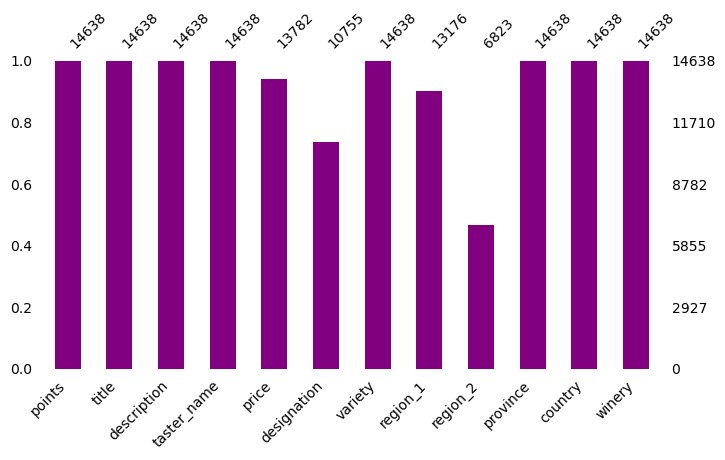

In [81]:
msno.bar(wine,color='purple',figsize=(8,4),fontsize = 10)

Price is missing columns and other regional descriptions are missing probably because they do not have an specificed area or are unknown. Will drop missing prices and replace missing values with 'None'. Outliers 3 standard deviations will be removed from the data set and saved into a specific outlier dataframe. 

## Feature Engineering
#### Text Preprocessing

As you can see, the review are full of \n characters and unwanted punctuation for modeling. To prepare the data for further EDA and modeling, the words need to be standardized,contractions removed, cleaned up, tokenized, and lemmatize. This small function below will use NLTK and contractionfunctions to prepare the 

In [82]:
#standardize text, remove stop words, clean speical characters, tonkenize, lemmatize
def standardization(input_data):
    english_stopwords = stopwords.words('english')
    regex = RegexpTokenizer(r'[\w\'\']+')
    
    conctract = contractions.fix(input_data)
    no_num = re.sub(r'\d+', '', conctract)
    tokens = regex.tokenize(no_num.lower())
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    lem = WordNetLemmatizer()
    lem_words = [lem.lemmatize(word) for word in tokens_wo_stopwords]
    
    return " ".join(lem_words)

In [83]:
standardization('700 Varieties of wine is a lot of $$$')

'variety wine lot'

In [84]:
#clean up text
wine['description'] = wine['description'].apply(standardization)

#len count of each description post cleaning
wine['text_len'] = wine['description'].apply(len)

#### Old World

Old World wine refers primarily to wine made in Europe but can also include other regions of the Mediterranean basin with long histories of winemaking such as North Africa and the Near East. The phrase is often used in contrast to "New World wine" which refers primarily to wines from New World wine regions such as the United States, Australia, South America and South Africa. 

In [85]:
new_world_countries = ['Argentina', 'Australia', 'Canada', 'Chile', 'Mexico', 'New Zealand', 'South Africa', 'US']
wine['old_world'] = (~wine['country'].isin(new_world_countries)).astype('int')

In [86]:
#drop null prices
wine.dropna(subset='price', inplace = True)

#fill unknown regional descriptions with None
null_col = [col for col in wine.columns[wine.isna().sum() > 0]]
wine.fillna('None',inplace=True)

#Remove Price Outilers that are three standard deviations away from the mean
wine_no = wine[(np.abs(stats.zscore(wine['price'])) <= 3)]

#Create new outilers dataframe = wine[(np.abs(stats.zscore(wine['price'])) >= 3)]
wine_o = wine[(np.abs(stats.zscore(wine['price'])) > 3)]

# EDA
### Data EDA
- The majority of the wine data was not relevant to the problem at hand so EDA completed was to find interesting wines and regions. Some of the highest rated wines under $20 were made in Spain from Tempranillo grapes. Another high scoring wine came from a region typically over looked: Hungary.

In [387]:
#how many unique wine botles were review
print('Unique wine bottles:',len(wine['title'].unique()))
#how many unique reviewer
print('Unique wine reviewers:',len(wine['taster_name'].unique()))
#how many unique wine varieties
print('Unique wine varieties:',len(wine['variety'].unique()))
wine_no.describe()
print('Unique countries:',len(wine['country'].unique()))
print('Unique wineries:',len(wine['winery'].unique()))


Unique wine bottles: 13782
Unique wine reviwers: 18
Unique wine varieties: 328
Unique countries: 23
Unique wineries: 4496


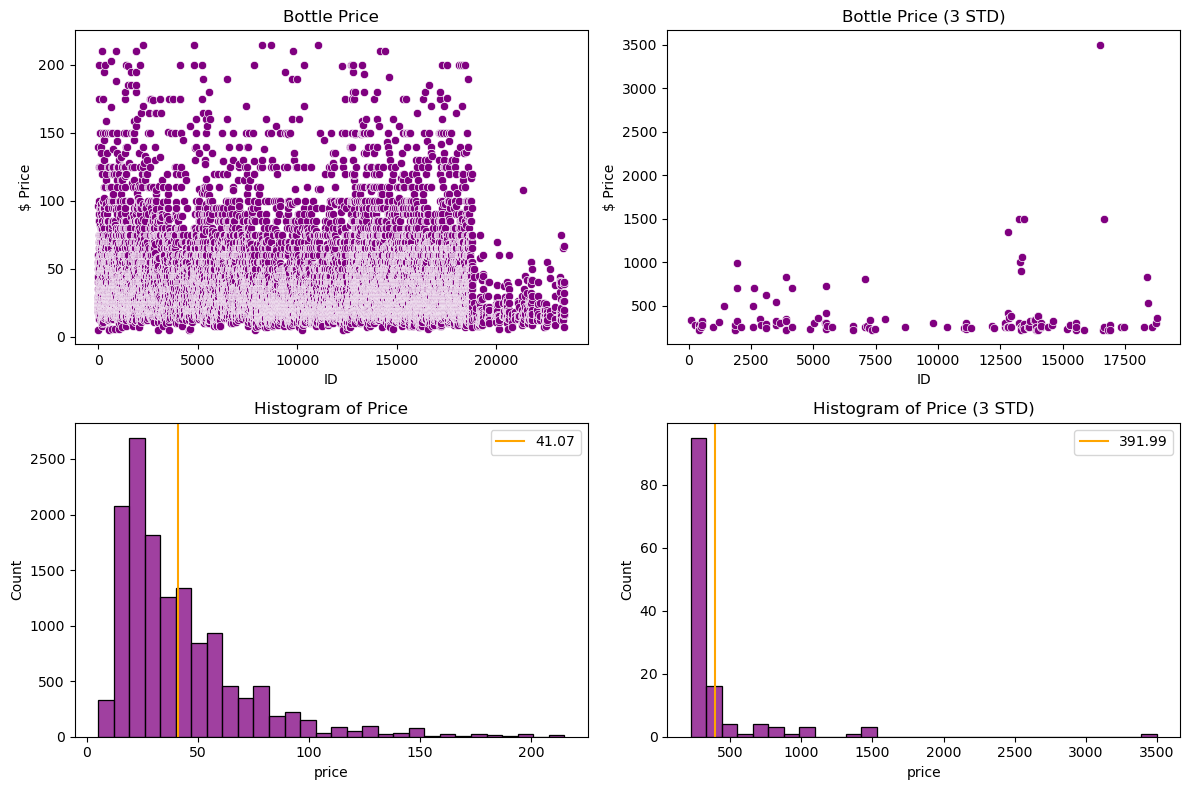

In [88]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
sns.scatterplot(y = wine_no['price'],x = wine_no.index,color = 'purple',ax=ax[0,0])
ax[0,0].set_title('Bottle Price')
ax[0,0].set_ylabel('$ Price')
ax[0,0].set_xlabel('ID')

sns.histplot(wine_no['price'],bins = 30,color='purple', ax=ax[1,0])
ax[1,0].set_title('Histogram of Price')
ax[1,0].axvline(wine_no['price'].mean(),color='orange',label =round(wine_no['price'].mean(),2))
ax[1,0].legend()

sns.scatterplot(y = wine_o['price'],x = wine_o.index,color = 'purple',ax=ax[0,1])
ax[0,1].set_title('Bottle Price (3 STD)')
ax[0,1].set_ylabel('$ Price')
ax[0,1].set_xlabel('ID')

sns.histplot(wine_o['price'],bins=30,color='purple',ax=ax[1,1])
ax[1,1].set_title('Histogram of Price (3 STD)')
ax[1,1].axvline(wine_o['price'].mean(), color='orange',label =round(wine_o['price'].mean(),2))
ax[1,1].legend()

fig.tight_layout()

- With outliers removed, we can see that majority of bottles fall below the $50 price point. Since the distribution is skewed to the left, the log mean will be used for further exploration. 
- A look at relationship between wine score and price is in order. Will there be a correlation between price and points given? Does the length of the review have a correlation between price or points given? 

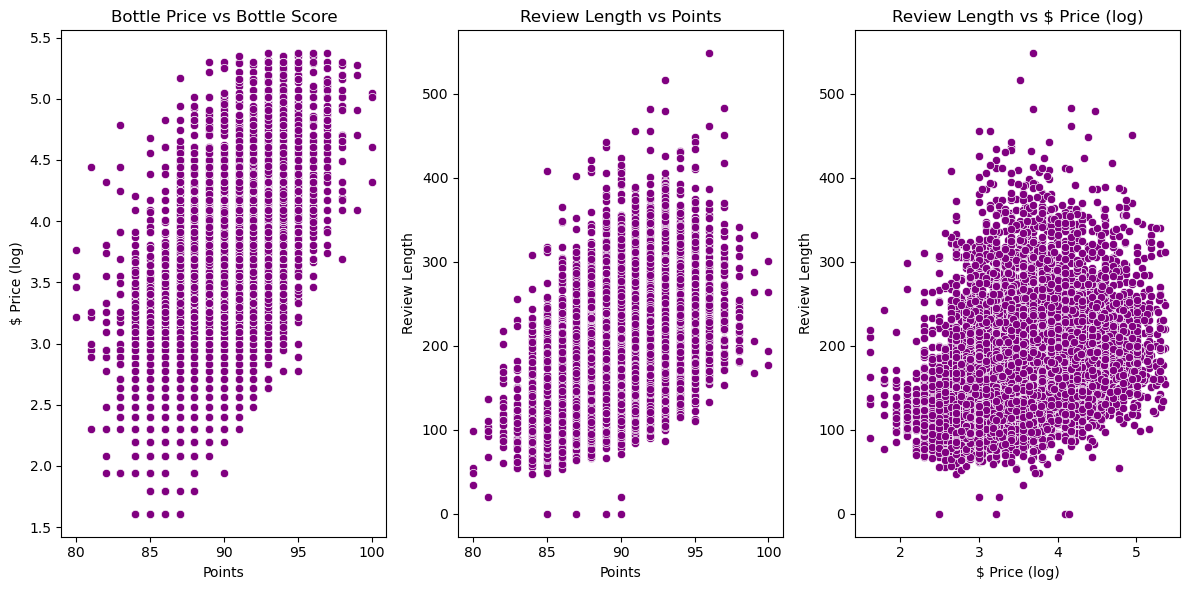

In [103]:
fig,ax = plt.subplots(1,3,figsize=(12,6))

#correlation between log(price) and quality of wine? 
sns.scatterplot(y = np.log(wine_no['price']),x = wine_no['points'], color = 'purple',ax=ax[0])
ax[0].set_title('Bottle Price vs Bottle Score')
ax[0].set_xlabel('Points')
ax[0].set_ylabel('$ Price (log)')

#correlation between points and length of post? 
sns.scatterplot(y = wine_no['text_len'],x = wine_no['points'], color = 'purple',ax=ax[1])
ax[1].set_title('Review Length vs Points')
ax[1].set_xlabel('Points')
ax[1].set_ylabel('Review Length')

#correlation between points and length of post? 
sns.scatterplot(y = wine_no['text_len'],x = np.log(wine_no['price']), color = 'purple',ax=ax[2])
ax[2].set_title('Review Length vs $ Price (log)')
ax[2].set_ylabel('Review Length')
ax[2].set_xlabel('$ Price (log)')

fig.tight_layout()

- There is both a positive correlation to Price and Points and Review Length and Points. Does the price effect the bais of the review or is there an actual advantage to quality with the high priced bottles. What bottles tend to have low prices but high scores? 
- 93 score is above the Q3, what bottles and varieties $20 and below?

In [433]:
wine_no.loc[(wine_no['points'] > 93) & (wine_no['price'] <= 20)][['points','country','title','variety']].sort_values(by='points',ascending = False)

,points,country,title,variety
3889,95,Spain,Rolland & Galarreta 2014 Tempranillo (Rioja),Tempranillo
5017,95,Australia,Chambers Rosewood Vineyards NV Muscat Blanc à ...,Muscat Blanc à Petits Grains
16454,95,Italy,Paltrinieri 2020 Radice (Lambrusco di Sorbara),Lambrusco di Sorbara
726,94,Australia,Chambers Rosewood Vineyards NV Muscadelle (Rut...,Muscadelle
3092,94,Spain,El Vinculo 2018 Crianza Tempranillo (La Mancha),Tempranillo
13786,94,US,Matchbook 2019 Tinto Rey Tempranillo (Dunnigan...,Tempranillo
14925,94,Italy,Cavicchioli 2020 Vigna del Cristo (Lambrusco ...,Lambrusco di Sorbara
15544,94,Australia,Forest Hill 2019 Highbury Fields Cabernet Sauv...,Cabernet Sauvignon


- Good to know...
- Lets look at the top reviewed grapes, countries,wineries,and proviences

In [143]:
#top 20 most reviewed wine varieties 
top_20 = wine_no['variety'].value_counts().head(20)
bottom_20 = wine_no['variety'].value_counts().tail(20)

#pricing of all wine varieties
most_ex = wine_no.groupby('variety')['price'].describe().sort_values(ascending=False, by='max')

#top 20 countries by count
country_20 = wine_no['country'].value_counts().head(20)
data1 = wine_no.loc[wine_no['country'].isin(country_20.index)]

#top 20 wineries by count
winery_20 = wine_no['winery'].value_counts().head(20)
data2 = wine_no.loc[wine_no['winery'].isin(winery_20.index)]

#top 20 provinces by count
provience_20 = wine_no['province'].value_counts().head(20)
data4 = wine_no.loc[wine_no['province'].isin(provience_20.index)]

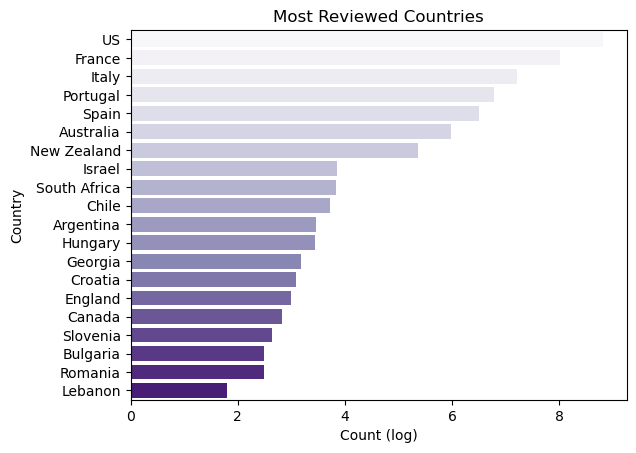

In [415]:
sns.barplot(x = np.log(country_20.values), y = country_20.index, palette= 'Purples')
plt.title('Most Reviewed Countries')
plt.ylabel('Country')
plt.xlabel('Count (log)');

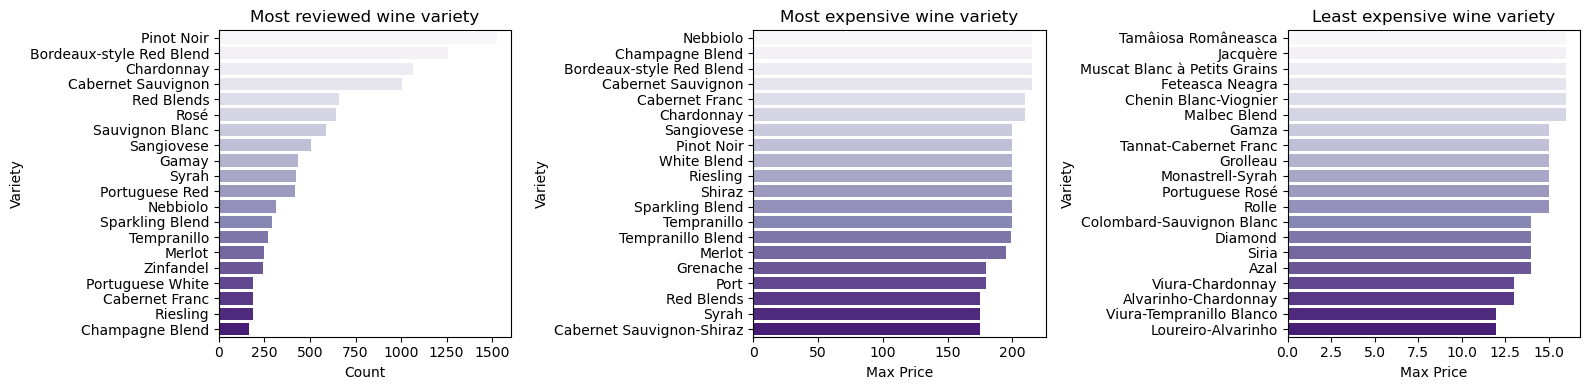

In [392]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

#20 most reviewed variety 
sns.barplot(y = top_20.index[:20],x = top_20.head(20),palette='Purples',ax=ax[0])
ax[0].set_title('Most reviewed wine variety')
ax[0].set_ylabel('Variety')
ax[0].set_xlabel('Count')

#20 most expensive wine varieties
sns.barplot(y = most_ex['max'].head(20).index,x = most_ex['max'].head(20),palette='Purples',ax=ax[1])
ax[1].set_title('Most expensive wine variety')
ax[1].set_ylabel('Variety')
ax[1].set_xlabel('Max Price')


#20 most expensive wine varieties
sns.barplot(y = most_ex.tail(20).index,x = most_ex['max'].tail(20),palette='Purples',ax=ax[2])
ax[2].set_title('Least expensive wine variety')
ax[2].set_ylabel('Variety')
ax[2].set_xlabel('Max Price')

fig.tight_layout()

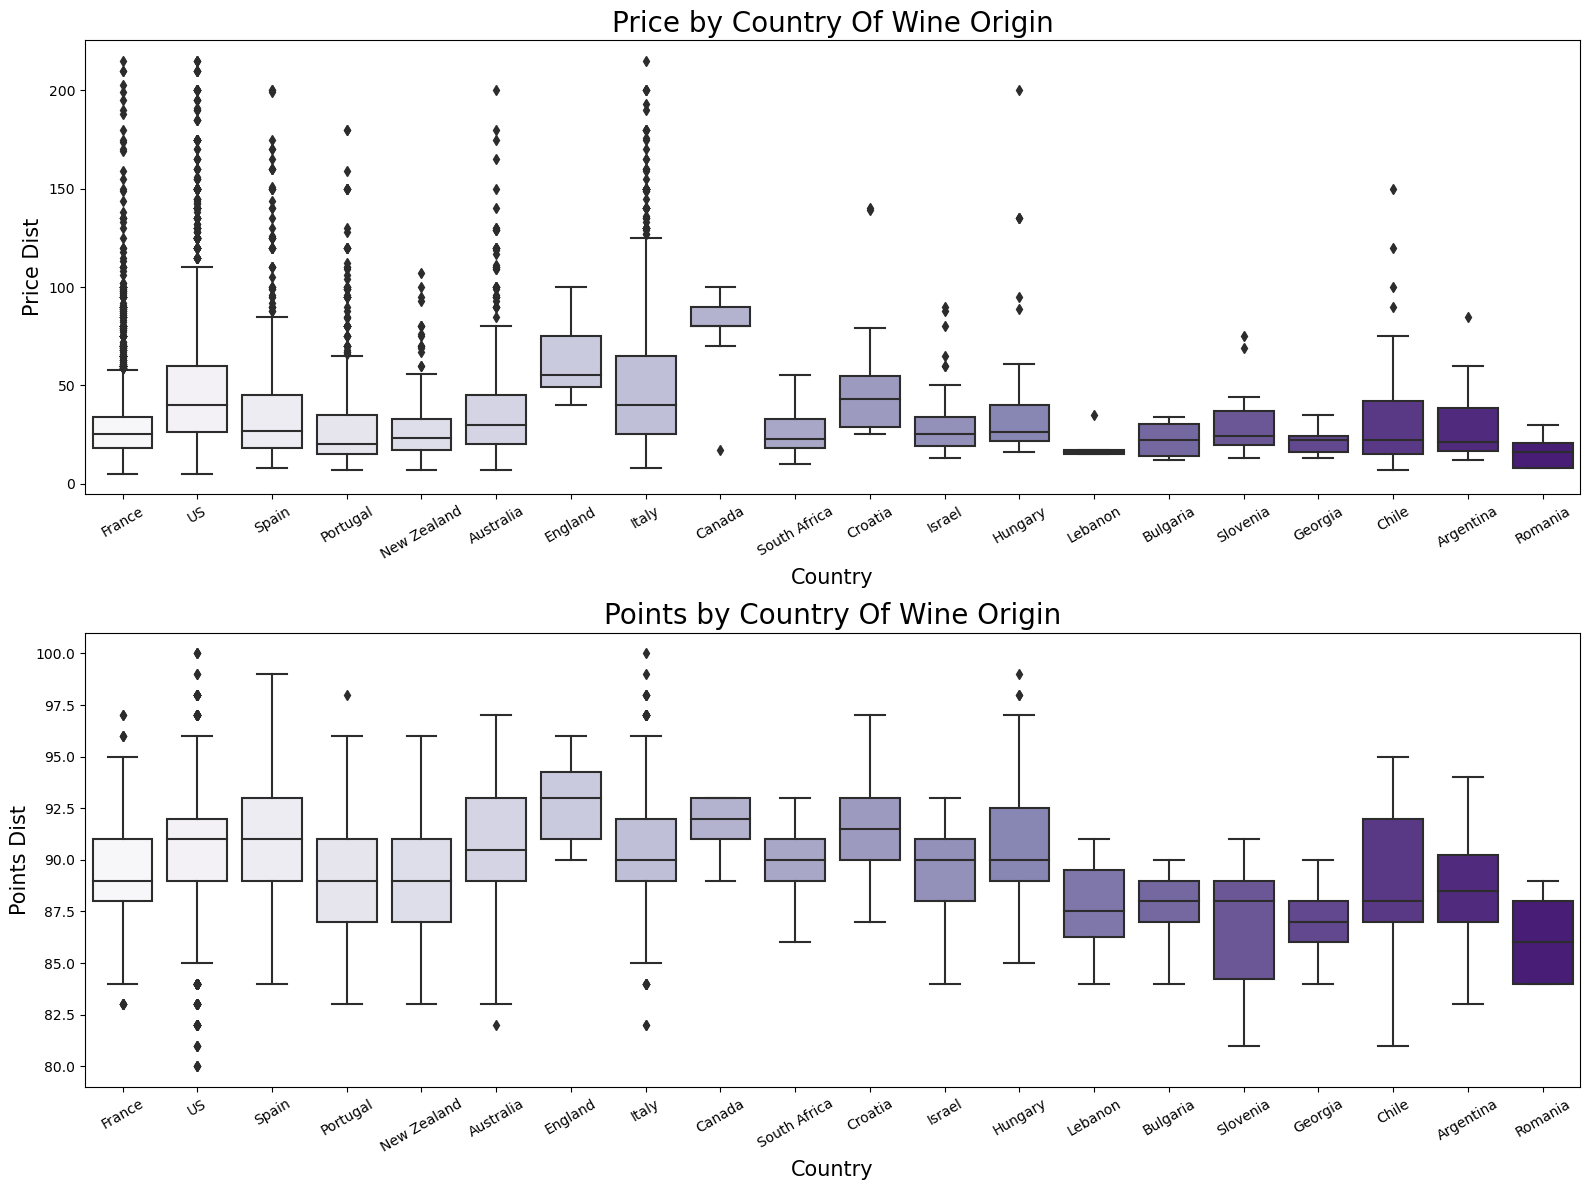

In [263]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

sns.boxplot(y='price', x='country',data=data1 ,ax=ax[0],palette='Purples')
ax[0].set_title("Price by Country Of Wine Origin", fontsize=20)
ax[0].set_xlabel("Country", fontsize=15)
ax[0].set_ylabel("Price Dist", fontsize=15)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=30)

sns.boxplot(x='country', y='points',data=data1,ax=ax[1],palette='Purples')
ax[1].set_title("Points by Country Of Wine Origin", fontsize=20)
ax[1].set_xlabel("Country", fontsize=15)
ax[1].set_ylabel("Points Dist", fontsize=15)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);

fig.tight_layout()

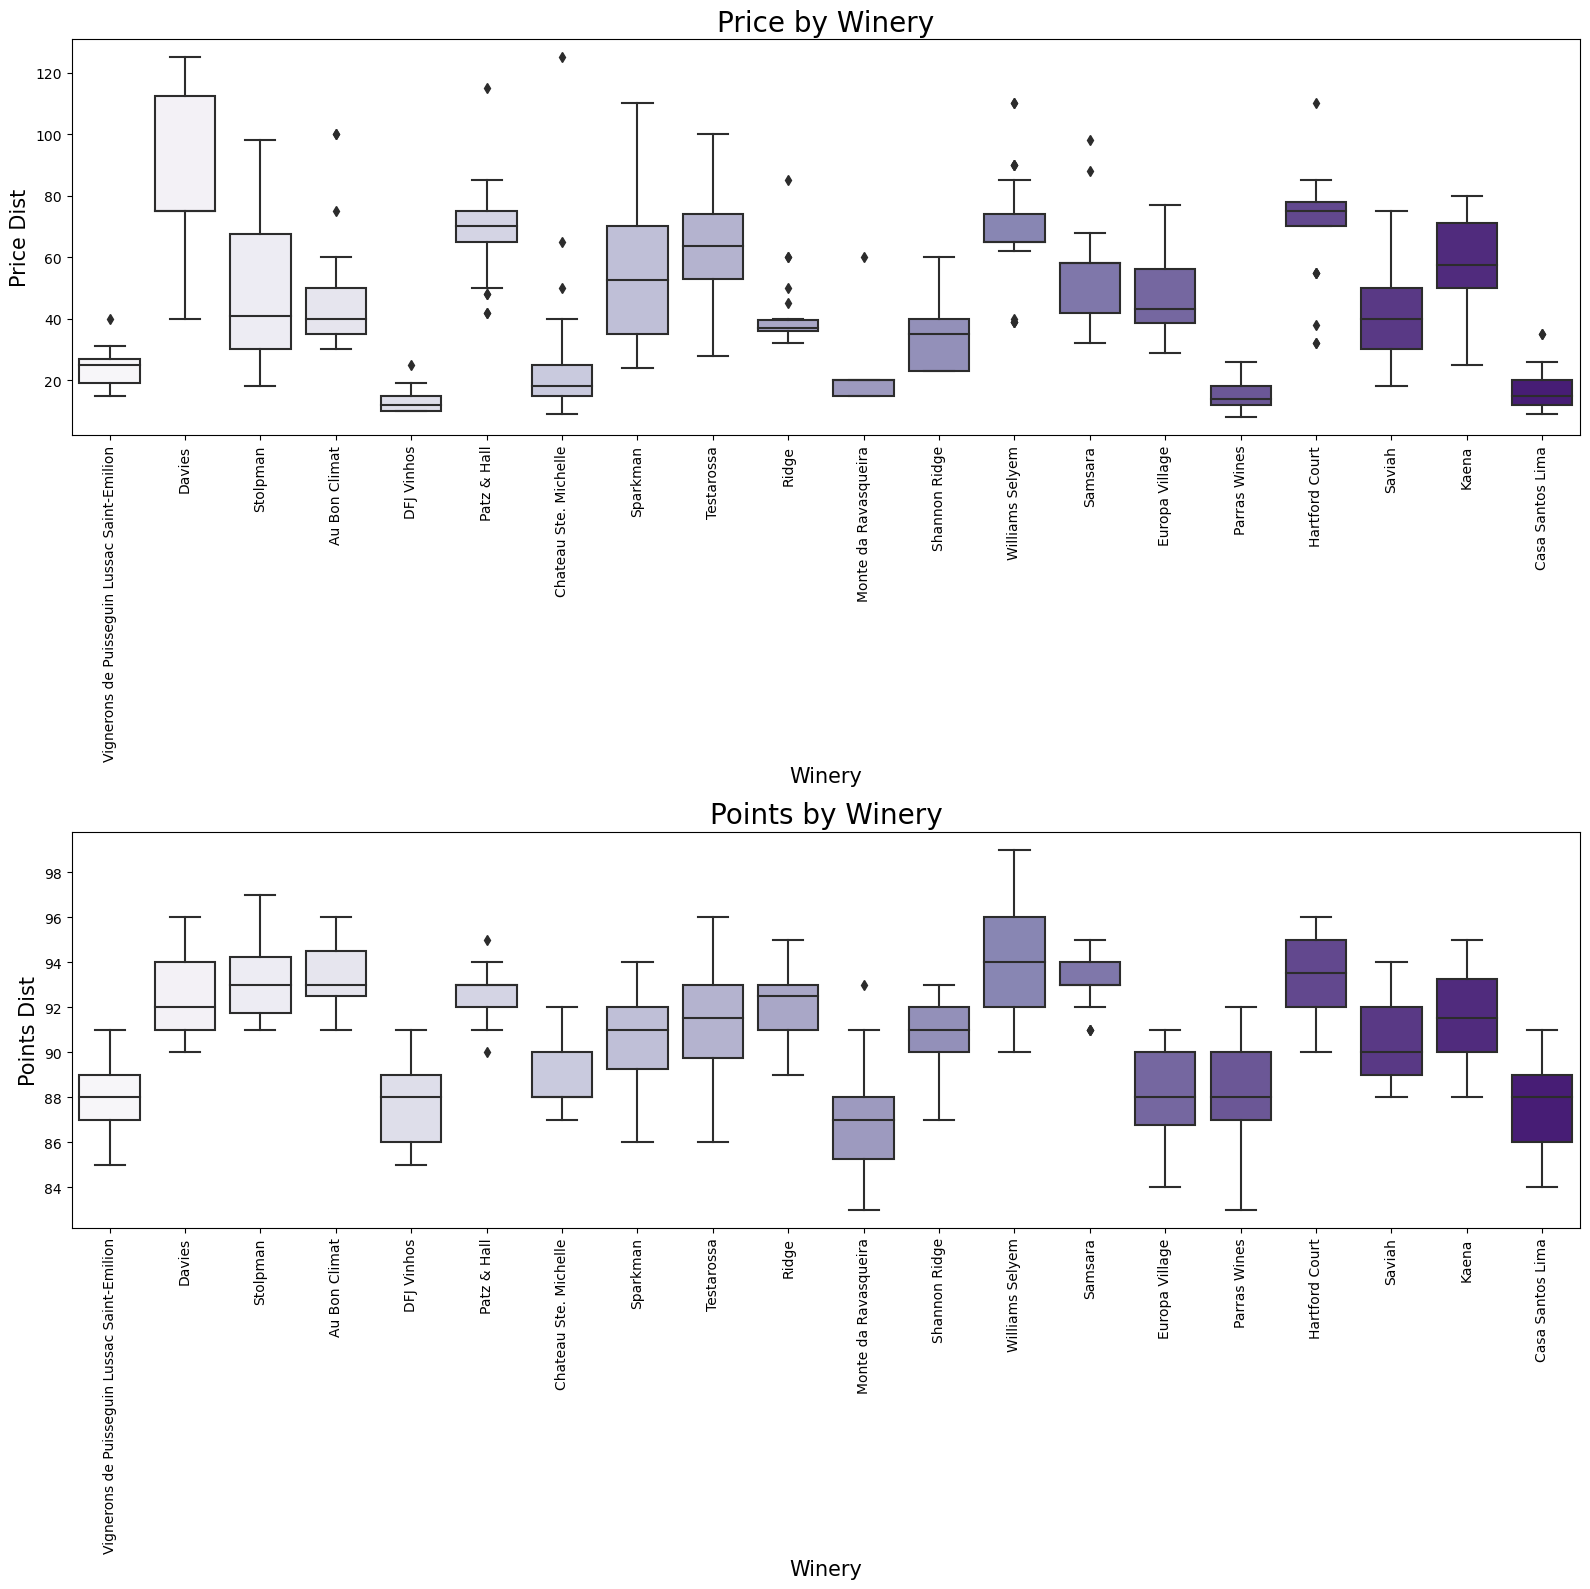

In [262]:
fig,ax = plt.subplots(2,1,figsize=(16,16))

sns.boxplot(x='winery', y='price',data=data2, ax=ax[0],palette='Purples')
ax[0].set_title("Price by Winery", fontsize=20)
ax[0].set_xlabel("Winery", fontsize=15)
ax[0].set_ylabel("Price Dist", fontsize=15)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90);


sns.boxplot(x='winery', y='points',data=data2,ax=ax[1],palette='Purples')
ax[1].set_title("Points by Winery", fontsize=20)
ax[1].set_xlabel("Winery", fontsize=15)
ax[1].set_ylabel("Points Dist", fontsize=15)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
fig.tight_layout()

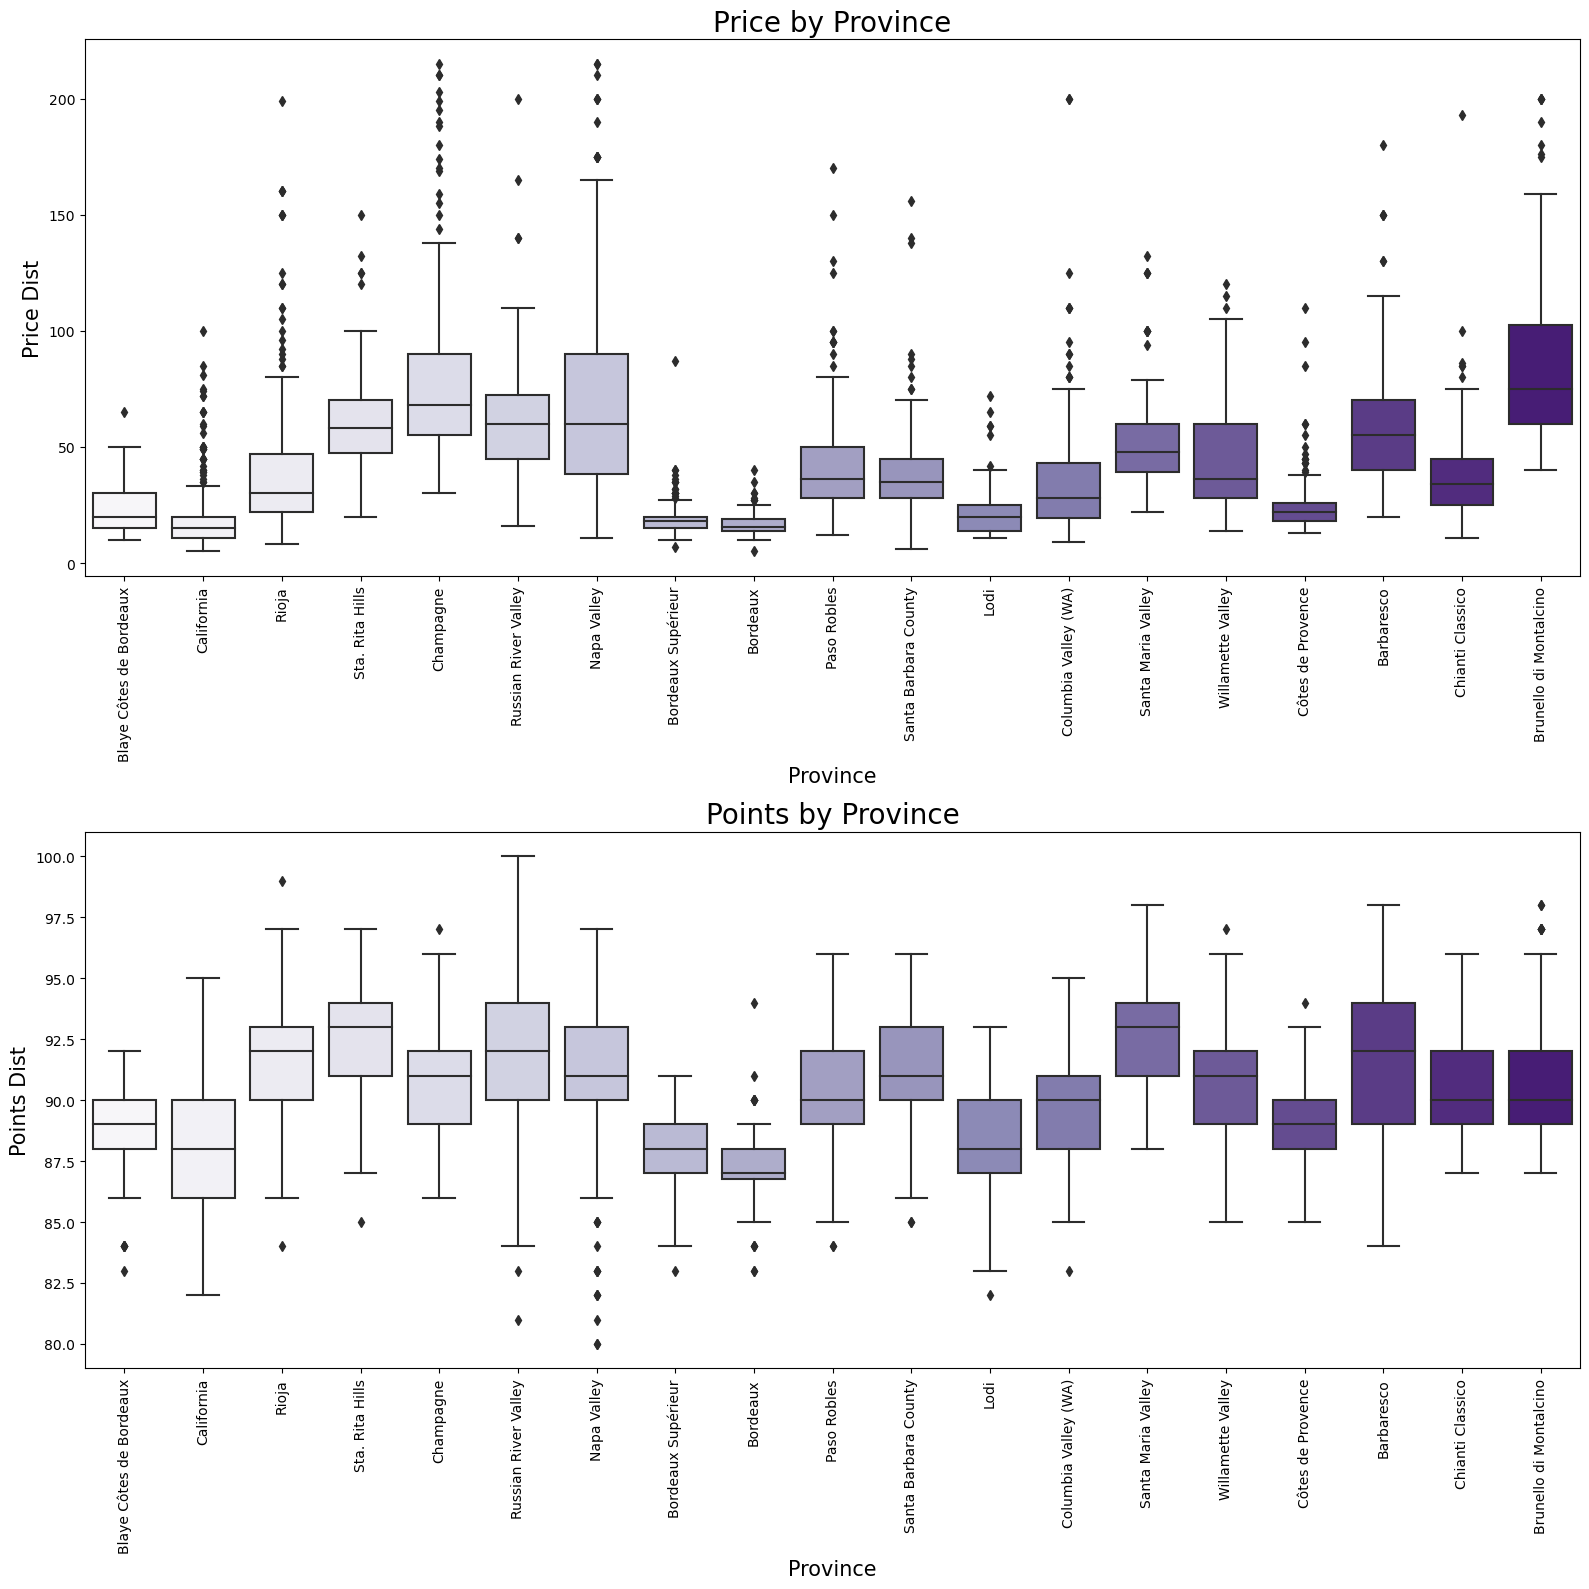

In [385]:
fig,ax = plt.subplots(2,1,figsize=(16,16))

sns.boxplot(x='region_1', y='price',data=data3, ax=ax[0],palette='Purples')
ax[0].set_title("Price by Province", fontsize=20)
ax[0].set_xlabel("Province", fontsize=15)
ax[0].set_ylabel("Price Dist", fontsize=15)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90);


sns.boxplot(x='region_1', y='points',data=data3,ax=ax[1],palette='Purples')
ax[1].set_title("Points by Province", fontsize=20)
ax[1].set_xlabel("Province", fontsize=15)
ax[1].set_ylabel("Points Dist", fontsize=15)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
fig.tight_layout()

In [434]:
hungary = wine.loc[(wine['country'] == 'Hungary')|(wine['country'] == 'Croatia')].sort_values(by=['points','price'],ascending=False)
hungary.loc[hungary['price'] < 20][['points','country','title','variety']]

,points,country,title,variety
18338,92,Hungary,Dúzsi Tamás 2020 Kékfrankos Rosé (Szekszárd),Rosé
15466,91,Hungary,Royal Tokaji 2019 The Oddity Dry (Tokaji),Furmint
15636,91,Hungary,Gál Tibor 2020 Egri Csillag White (Eger),White Blend


### Text EDA
- Since modeling was based on the assumption that the classification is possible through text, there needed to be significant information found within the reviews. TFID vectorizor was used to separate words that were specific to grape varieties. As seen in the graphs, there is plenty of information found that could be used as features within the classifaction model.

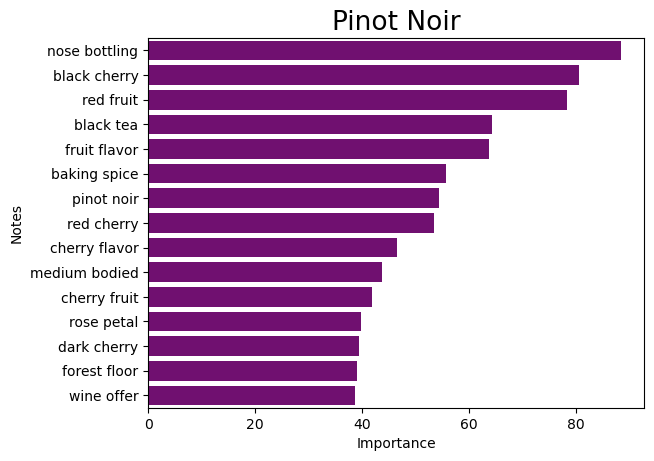

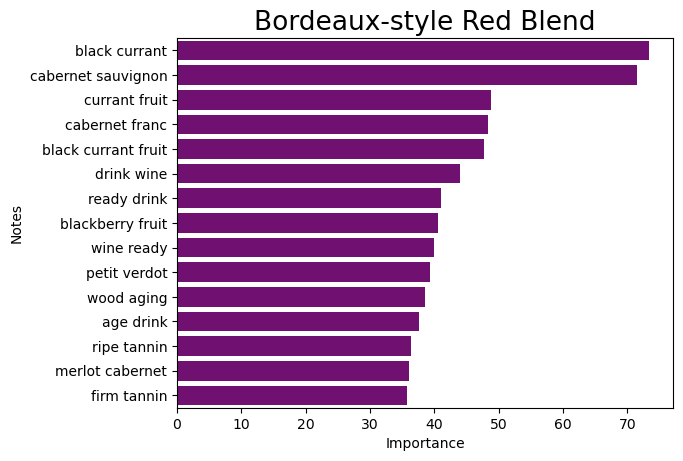

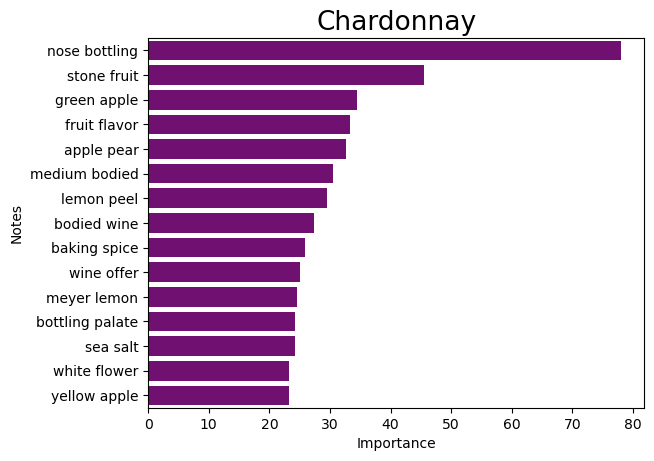

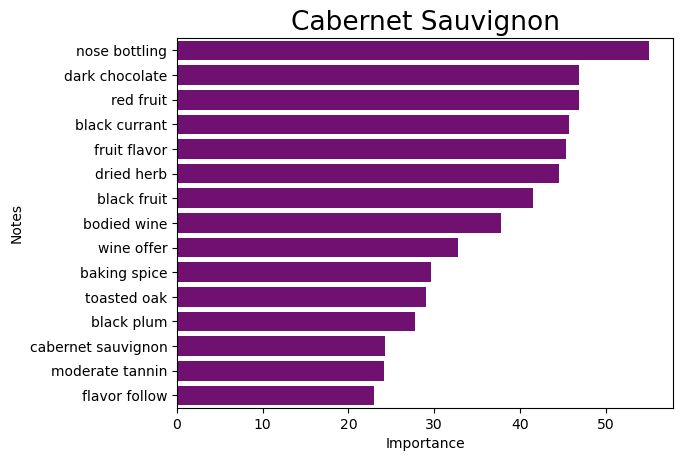

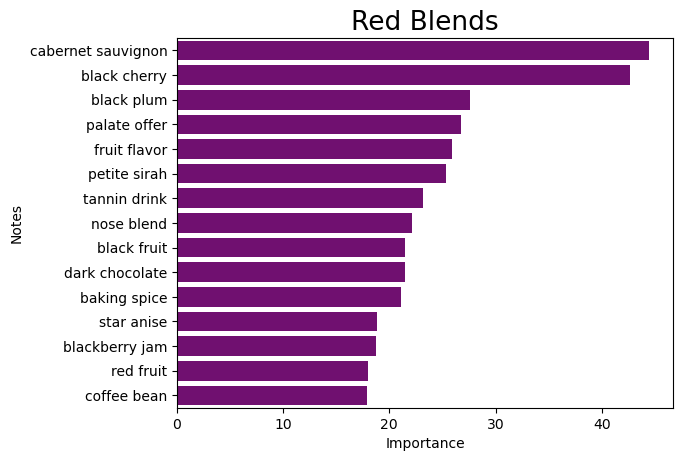

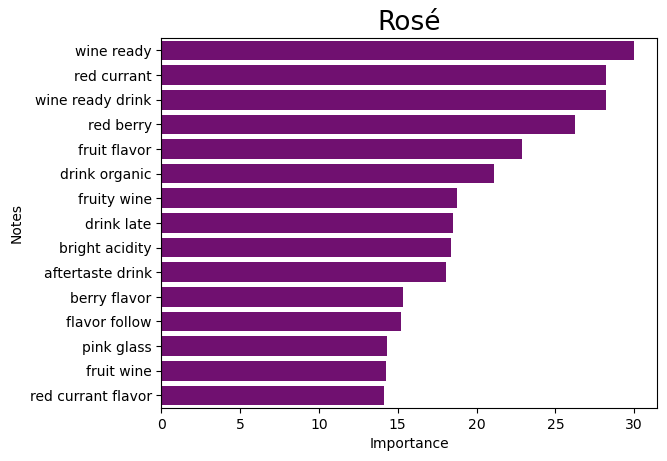

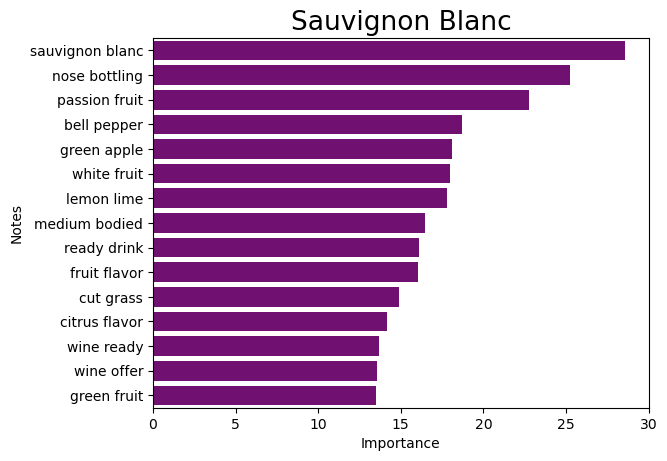

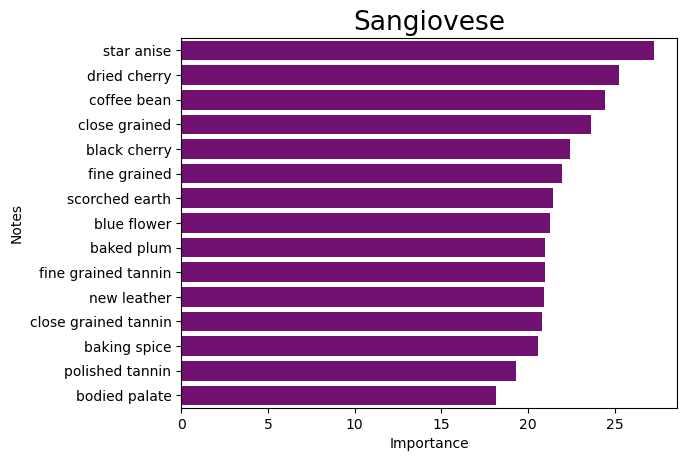

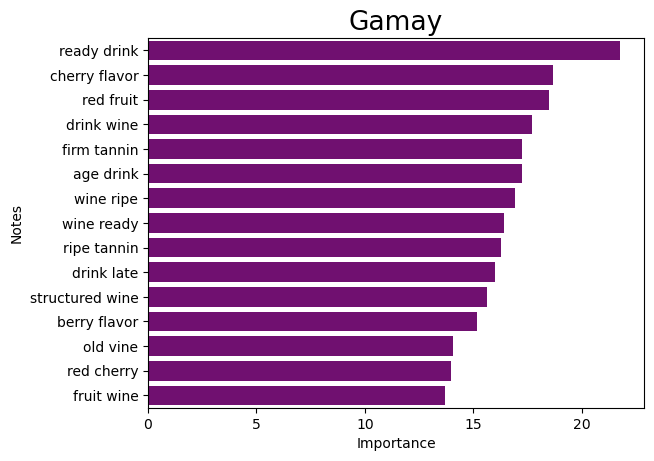

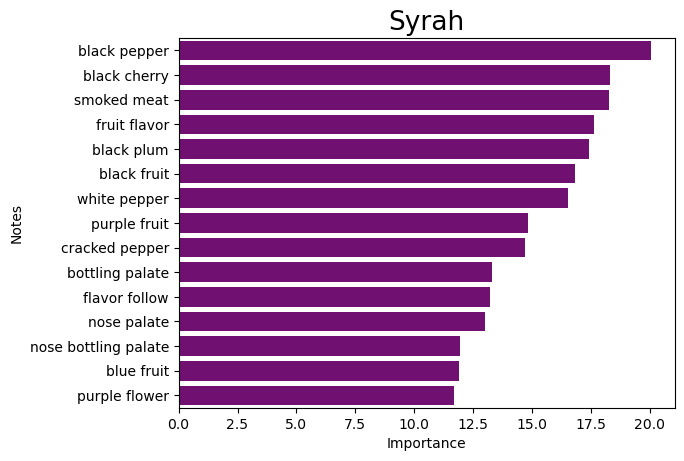

In [366]:
#for each grape variety, calculate the most important words

for grape in top_20[:10].index:
    #Vectorize text and remove common stop words
    tfid= TfidfVectorizer(stop_words = 'english',max_features=100,ngram_range=(2, 3),max_df=.2)
    results = tfid.fit_transform(wine_no[(wine_no['variety'] == grape)]['description'])
    words = tfid.get_feature_names_out()
    scores = (results.toarray()) 
    sums = results.sum(axis = 0) 
    data1 = [] 

    for col, term in enumerate(words): 
        data1.append( (term, sums[0,col] )) 
    ranking = pd.DataFrame(data1, columns = ['word','rank']) 
    top_words = (ranking.sort_values('rank', ascending = False))[:15]
    sns.barplot(y='word', x='rank', data=top_words,
                color='Purple', orient='h')
    plt.title(f"{grape}", fontsize=19)
    plt.ylabel('Notes')
    plt.xlabel("Importance")
    plt.show()

In [370]:
def standardization2(input_data):
    english_stopwords = stopwords.words('english')
    regex = RegexpTokenizer(r'[\w\'\']+')
    
    conctract = contractions.fix(input_data)
    no_num = re.sub(r'\d+', '', conctract)
    tokens = regex.tokenize(no_num.lower())
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    lem = WordNetLemmatizer()
    lem_words = [lem.lemmatize(word) for word in tokens_wo_stopwords]
    
    return (lem_words)

In [371]:
data = wine_no['description'].apply(standardization2)

In [372]:
model = w2v.Word2Vec(data,min_count = 1, vector_size = 100, window = 5)

In [442]:
model.wv.similar_by_word('nutmeg')

[('cinnamon', 0.9678986668586731),
 ('caramel', 0.9590651392936707),
 ('vanilla', 0.9279819130897522),
 ('cardamom', 0.9178624749183655),
 ('fig', 0.8988614678382874),
 ('clove', 0.898017942905426),
 ('cola', 0.8975136876106262),
 ('espresso', 0.890975832939148),
 ('cocoa', 0.8893072605133057),
 ('butterscotch', 0.8860865831375122)]

In [374]:
model.wv.similar_by_word('vanilla')

[('cinnamon', 0.9279916286468506),
 ('nutmeg', 0.927981972694397),
 ('caramel', 0.8930220603942871),
 ('accented', 0.8818524479866028),
 ('clove', 0.8721109628677368),
 ('accent', 0.8717387914657593),
 ('backed', 0.8433220982551575),
 ('maple', 0.8357676863670349),
 ('espresso', 0.8305955529212952),
 ('butterscotch', 0.8197691440582275)]